## Introducción

Este trabajo consiste en analizar una serie de datos recoletados por la agencia gubernamental de recaudación de impuestos *FIUFIP*.

Buscaremos entender como se relacionan estos datos y determinar un metodo de si una persona tiene **altos ingresos** o **bajos ingresos** a partir de los datos recibidos, que consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.



## Objetivos

**Tarea**: explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados

* Saber cómo entender cada uno de los datos
* Saber cómo se relacionan entre sí 
* Saber si se puede sacar alguna conclusión o descubrir un patrón a partir de estos

**Adicionalmente**

* Saber cuáles son los factores más importantes que determinan si un usuario **tiene altos** o **bajos ingresos** {*varible_target*}.

**Baseline**: código simple 

* intente predecir el target (si el usuario tiene **altos ingresos** o **bajos ingresos**).

--- 

*No quieren nada complicado sino una serie muy simple de decisiones lógicas que les permitan en poco tiempo hacer una primera ronda de campaña digital.*

<span style="font-weight: bold; color:red"> DUDA: ¿CAMPAÑA DIGITAL? </span>

Se espera que este código simple (baseline) tenga una accuracy aceptable (mayor a ??%) y que esté basada y justificada en la investigación previa.

---


## Carga de librerias y dataset

Las librerias necesarias para este notebook serán las siguientes importadas:

In [1]:
from collections import Counter # se usará? la saqué del notebook "pandas introduccion"
import requests # se usará? la saqué del notebook "pandas introduccion"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        import pandas as pd


In [3]:
df = pd.read_csv("fiufip_dataset.csv")

Se renombra a las columnas en un formato mas comodo de manejar.

# Aplicando Ingeniería de Features

In [4]:
from sklearn.cluster import KMeans


## Verificando la "calidad" de los datos


### Chequeo de valores NULOS

Las posibles representaciones de valores nulos ingresados tales como '-', '?', ' ', etc se las reemplaza por el valor nulo NaN en caso de existir dichos valores representativos del nulo en las columnas tanto numericas como no numericas.

In [5]:
cantidad_NaN_agregados = 0
for una_columna in df.columns:
    if df[una_columna].astype(str).str.contains("[^A-Za-z0-9]+$").any():
         df[una_columna].replace(to_replace="[^A-Za-z0-9]+$", value=np.nan, regex=True, inplace=True)
         cantidad_NaN_agregados=cantidad_NaN_agregados+1    
print(f'Cantidad columnas modificadas agregando NaN por representación incorrecta del mismo: {cantidad_NaN_agregados}')

Cantidad columnas modificadas agregando NaN por representación incorrecta del mismo: 0


### Chequeo en variables numericas

Tambien habria revisar los features numericos con valores negativos


In [6]:
print(f'-> Cantidad de columnas numéricas: {df.describe().columns.size}')
df.describe().columns

-> Cantidad de columnas numéricas: 5


Index(['anios_estudiados', 'edad',
       'ganancia_perdida_declarada_bolsa_argentina',
       'horas_trabajo_registradas', 'tiene_alto_valor_adquisitivo'],
      dtype='object')

La unica que tendria sentido no modificar es la _'ganancia_perdida_declarada_bolsa_argentina'_ ya que puede admitir valores negativos. Las demas que contengan un negativo se las considera como **NaN**.


In [7]:
columnas_con_numeros = ['anios_estudiados', 'edad', 'tiene_alto_valor_adquisitivo']
(df[columnas_con_numeros] < 0).any()

anios_estudiados                False
edad                            False
tiene_alto_valor_adquisitivo    False
dtype: bool

Lo cual observamos que no hay valores incorrectos en dichas columnas.


## Chequeo de cada feature individualmente


### Feature: rol_familiar_registrado

Algo que nos parecio raro al analizar cada valor de los features, es que especialmente el de *rol_familiar_registrado* tiene dos posibles valores iguales pero se tiene un dato de *casado* siendo *mujer*, como tambien *casada* siendo *hombre*

In [8]:
hombre_casada = (df.rol_familiar_registrado == 'casada') & (df.genero == 'hombre')
mujer_casado = (df.rol_familiar_registrado == 'casado') & (df.genero == 'mujer')
df[mujer_casado | hombre_casada]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
575,17,Palermo,relacion_de_dependencia,29,universidad_3_anio,matrimonio_civil,0,hombre,40,cristianismo,casada,1,directivo_gerente
7109,13,Palermo,relacion_de_dependencia,34,4_anio,matrimonio_civil,0,mujer,40,cristianismo,casado,0,ventas
27141,17,NaN,relacion_de_dependencia,36,universidad_3_anio,matrimonio_civil,0,hombre,60,cristianismo,casada,0,ventas


El cual puede que a la hora de la insercidf[mujer_casado | hombre_casada]ón de los datos no haya sido lo suficientemente inclusiva.
Cambiaremos el genero a ambos segun corresponda.

In [9]:
df['genero'].mask(hombre_casada, 'mujer', inplace=True)
df['genero'].mask(mujer_casado, 'hombre', inplace=True)

Refrescamos las variables booleanas y comprobamos que se haya reemplazado

In [10]:
hombre_casada = (df.rol_familiar_registrado == 'casada') & (df.genero == 'hombre')
mujer_casado = (df.rol_familiar_registrado == 'casado') & (df.genero == 'mujer')
df[mujer_casado | hombre_casada]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo


Tambien si miramos la cantidad valores que adapta *rol_familiar_registrado*

In [11]:
rolFamili = df.rol_familiar_registrado.value_counts(dropna=False)
print(f'Hay un total de {len(rolFamili)}')
display(rolFamili)
print('')

Hay un total de 6


casado         13193
sin_familia     8305
con_hijos       5068
soltero_a       3446
casada          1568
otro             981
Name: rol_familiar_registrado, dtype: int64

Aca veo que hay rol de *soltero_a*, el cual no diferencia de mujeres y hombres pero si le pedis que los diferencie solo mandas el comando!

In [12]:
df[df.rol_familiar_registrado == 'soltero_a'].genero.value_counts(dropna=False)

mujer     2654
hombre     792
Name: genero, dtype: int64

No se si eso podria ser interesante de analizar... Pero podrias saber la cantidad de mujeres que le corresponde, muy facilmente.

Y si miro la tabla de nuevo, tenes *casada* y *casado*. 

No seria mejor unir en *casada_o* ¿?

Despues, si queres diferenciar cuales son hombres y mujeres de ese rol, simplemente te fijas su genero.

In [13]:
casada_mujer_o_casado_hombre = (df.rol_familiar_registrado == 'casado' ) | (df.rol_familiar_registrado == 'casada') 
df['rol_familiar_registrado'].mask(casada_mujer_o_casado_hombre, 'casado_a', inplace=True)

Si vuelvo a analizar.. Prescindimos de un rol y lo unimos

In [14]:
rolFamili = df.rol_familiar_registrado.value_counts(dropna=False)
print(f'Hay un total de {len(rolFamili)}')
display(rolFamili)
print('')

Hay un total de 5


casado_a       14761
sin_familia     8305
con_hijos       5068
soltero_a       3446
otro             981
Name: rol_familiar_registrado, dtype: int64

Si queres saber la informacion de si es hombre o mujer, tal como nos decia la tabla, simplemente le impogno esa condicion

In [15]:
df[df.rol_familiar_registrado == 'casado_a'].genero.value_counts(dropna=False)

hombre    13193
mujer      1568
Name: genero, dtype: int64

El cual coincide con la informacion que nos decia antes la tabla separadamente de *casada* y *casado*. 

En conclusion se puede recudir la cardinalidad un 16%. 

<span style="font-weight: bold; color:red"> INVESIGAR A VER SI ESTA BIEN DICHO ESA FRASE</span>

### Feature: *estado_marital*

In [16]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado_a,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado_a,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casado_a,0,profesional_especializado


Cambiamos nombre de 3 tipos del feature *estado_marital*

In [17]:
divorciado = df.estado_marital == 'divorciado' 
separado = df.estado_marital == 'separado'
df['estado_marital'].mask(divorciado, 'divorciado_a', inplace=True)
df['estado_marital'].mask(separado, 'separado_a', inplace=True)

## Eliminacion de muestras duplicadas

In [18]:
size_antes = len(df)
df = df.drop_duplicates()
size_despues = len(df)
print(f'se eliminaron: {size_despues-size_antes} filas duplicadas')

se eliminaron: -3466 filas duplicadas


## Conversion de Variables

### Conversion de variables categoricas

#### Categóricas de baja cardinalidad

In [19]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado_a,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado_a,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado_a,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casado_a,0,profesional_especializado


CONVERSION BAJA CARDINALIDAD EN CATEGORICAS.

Tirandole un **Ordinal Encoder (Label Encoder idem)**.. en vez de ver Strings en "estado_marital", ves numeros en cada string que haya!
Y luego, el modelo ML laburara mejor asi, y tmb tenes funcion inversa que podes ver que le correspondia a ese numero.

Tambien tenias el **One Hot Encoding**. Crea una columna binaria por cada valor de la variable... O sea, tenes 3 colores de ojos en una columna, entonces, tendrias 3 columnas, pero como regla general para evitar problema colinealidad es suficiente con 'n-1' columnas, o sea, 2 columnas.
En esa columna representas 1s y 0s.

-----
En esta parte, yo veo que a todas de baja cardinalidad podrias aplicar alguna de estos 2 metodos. Pero eso sirivria mas en la 2° parte del TP cuando hagamos ML y necesite numeros posta y NO strings como ahora (ejemplo, genero: mujer y hombre.. eso a futuro para el ML lo ponemos como 1 y 0 asi labura m ejor el ML)

Pero que se yo.. ¿que hacemos? Dejamos asi y listo? Ojo quizas estoy entendiendo mal esas cosas...



-----
**Yo entendí que esto es para las categoricas, no representntan una nocion de orden!!!**



#### Categóricas de alta cardinalidad

In [20]:
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado_a,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado_a,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado_a,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casado_a,0,profesional_especializado


##### Feature: *barrios*

Aca yo veo el claro ejemplo de los Barrios.

In [21]:
 barrios = df.barrio.value_counts(dropna=False, normalize=True) * 100
print(f'Hay un total de {len(barrios)}') 
display(barrios)
print('')

Hay un total de 42


Palermo                88.400069
Belgrano                2.175632
NaN                     1.993470
San Isidro              0.680529
Villa Urquiza           0.470871
Recoleta                0.415879
La Boca                 0.391820
Agronomia               0.364324
Almagro                 0.343702
Balvanera               0.326517
Puerto Madero           0.309332
Caballito               0.278398
Boedo                   0.274961
Barracas                0.257776
Chacarita               0.250902
Coghland                0.240591
Floresta                0.230280
Colegiales              0.213095
Constitucion            0.213095
Flores                  0.206221
Liniers                 0.202784
Monte Castro            0.175288
Mataderos               0.151229
Nueva Pompeya           0.147792
Monserrat               0.127170
nuñez                   0.116859
Parque Chacabuco        0.106548
Parque Avellaneda       0.099673
Villa Luro              0.099673
Parque Chas             0.096236
La Paterna

42 barrios, y solo el 89.5% esta en Palermo... altisima Cardinalidad...

Palermo          25720
Belgrano           633
NaN                580
San Isidro         198
Villa Urquiza      137
Recoleta           121
La Boca            114
Agronomia          106
Almagro            100
Balvanera           95
Name: barrio, dtype: int64

[]

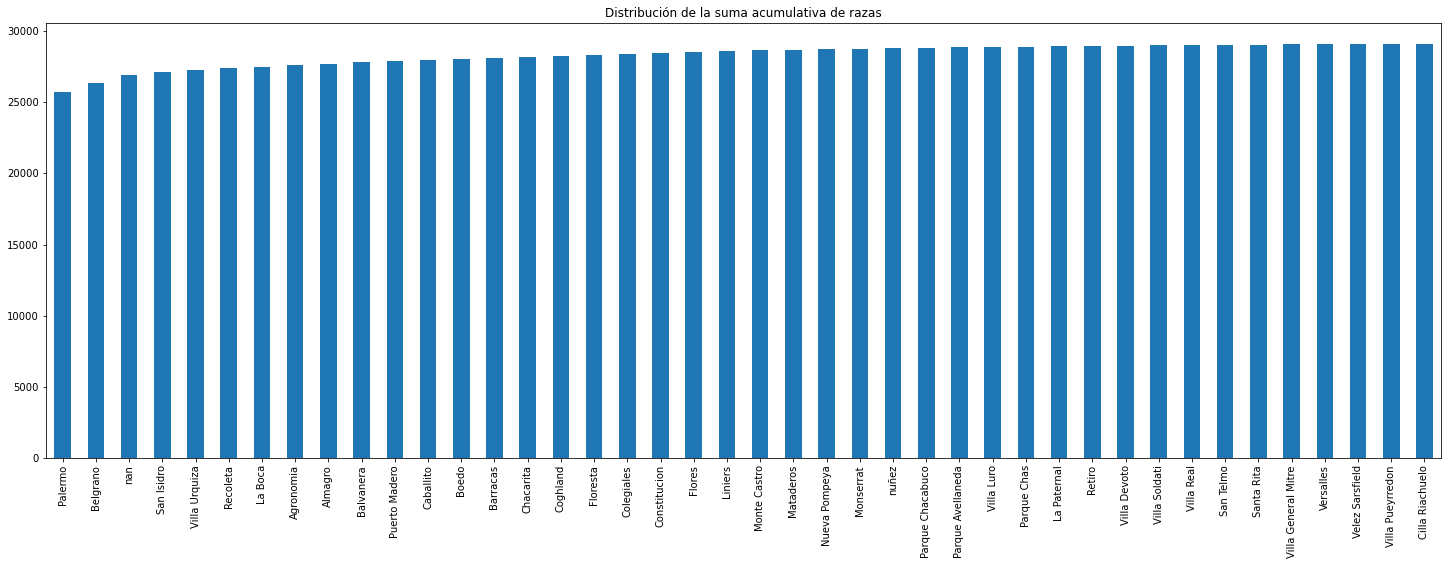

In [22]:
barrios_unicos = df['barrio'].value_counts(dropna=False)
display(barrios_unicos.head(10))
barrios_unicos.cumsum().plot(
    kind='bar', title="Distribución de la suma acumulativa de razas", figsize=(25, 8)
)
plt.plot()

Ahi en el grafico, fijate el primero de 'Palermo' esta al 90% lleno.. podrias quedarte solo con el 95% y reduciria muchisimo la cardinalidad del mismo

In [23]:
df['barrio'].value_counts(dropna=False)

Palermo                25720
Belgrano                 633
NaN                      580
San Isidro               198
Villa Urquiza            137
Recoleta                 121
La Boca                  114
Agronomia                106
Almagro                  100
Balvanera                 95
Puerto Madero             90
Caballito                 81
Boedo                     80
Barracas                  75
Chacarita                 73
Coghland                  70
Floresta                  67
Colegiales                62
Constitucion              62
Flores                    60
Liniers                   59
Monte Castro              51
Mataderos                 44
Nueva Pompeya             43
Monserrat                 37
nuñez                     34
Parque Chacabuco          31
Parque Avellaneda         29
Villa Luro                29
Parque Chas               28
La Paternal               23
Retiro                    20
Villa Devoto              19
Villa Soldati             19
Villa Real    

In [24]:
barrios = df['barrio'].value_counts(dropna=False)


In [25]:

barris_achicado = barrios[barrios < 35 ].index
barris_achicado


Index(['nuñez', 'Parque Chacabuco', 'Parque Avellaneda', 'Villa Luro',
       'Parque Chas', 'La Paternal', 'Retiro', 'Villa Devoto', 'Villa Soldati',
       'Villa Real', 'San Telmo', 'Santa Rita', 'Villa General Mitre',
       'Versalles', 'Velez Sarsfield', 'Villa Pueyrredon', 'Cilla Riachuelo'],
      dtype='object')

In [26]:
#df['barrio'] = df.barrio.replace(to_replace=barris_achicado, value='Otro',   inplace=False )

In [27]:
df.barrio.value_counts(dropna=False,normalize=True) * 100

Palermo                88.400069
Belgrano                2.175632
NaN                     1.993470
San Isidro              0.680529
Villa Urquiza           0.470871
Recoleta                0.415879
La Boca                 0.391820
Agronomia               0.364324
Almagro                 0.343702
Balvanera               0.326517
Puerto Madero           0.309332
Caballito               0.278398
Boedo                   0.274961
Barracas                0.257776
Chacarita               0.250902
Coghland                0.240591
Floresta                0.230280
Colegiales              0.213095
Constitucion            0.213095
Flores                  0.206221
Liniers                 0.202784
Monte Castro            0.175288
Mataderos               0.151229
Nueva Pompeya           0.147792
Monserrat               0.127170
nuñez                   0.116859
Parque Chacabuco        0.106548
Parque Avellaneda       0.099673
Villa Luro              0.099673
Parque Chas             0.096236
La Paterna

O sea.. mamdé un 1.03% a "Otro" lo cual no se si nos covneiene realizar esto ahora que no usamos modelos complejos de ML

Tampoco se si esta bien.. Tenias 100 personas o mas que mande a 'Otro'

Quizas perdi mucha informacion

Con Jorge.. él mostró un ejemplo y habia borrado solamente pocas personas.. o sea, ponele que era 1 o 2 personas por barrio por ejemplo 

----
Despues no se que otro Feature analizar segun la baja u alta cardinalidad para hacer una "Conversion" tampoco se si es tan necesario tal como dije por no usar tan complejos ML modelos..

### Conversion de variables numéricas

In [28]:
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,29095.000000,29095.000000,29095.000000,29095.000000,29095.000000
mean,14.073174,39.251521,1100.664857,40.637842,0.247809
std,2.743755,13.687358,7804.833367,12.735636,0.431748
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,38.000000,0.000000,40.000000,0.000000
75%,17.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


Tenias varios conceptos para aplicar a Numericos y que figuran en el notebook de 'feature_engineering'

#### Scalers

Es una transformación por la cual escalamos a un determinado rango/distribución.. ponele valores de peso y altura, te interesa que se distribuyan como una distribucion normal por ejemplo... Esto entiendo que no haria falta aplicar aca porque como no usamos modelos ML, tipo..

#### Discretización: Binarizer y KBinsDiscretizer

Discretización: Binarizer y KBinsDiscretizer
Esto lo que hace, *pasar de Continuo a Discreto*

Quizas para la ganancia perdida decalrad de la bolsa..al tener muchos valores,seria continua ahi deberiamos discretizar?

Ahi deberiamos discretizar?

O no hace falta por no usar ML complejo?#### Discretización: Binarizer y KBinsDiscretizer

#### Outliers

In [29]:
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,29095.000000,29095.000000,29095.000000,29095.000000,29095.000000
mean,14.073174,39.251521,1100.664857,40.637842,0.247809
std,2.743755,13.687358,7804.833367,12.735636,0.431748
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,38.000000,0.000000,40.000000,0.000000
75%,17.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


Quizas si debamos aplicar ésto cuando analizemos bien las preguntas.. O sea, realizar una conversión para que algun que otro Outlier no nos rompa...

O ver bien qué hacer con los Outliers

horas_trabajo_registradas alguien puso 99 y no sé si sea coherente!

### Conversion variales ordinales

Aca si son variables con un cierto orden... Seria mejor asocialer un numero? 

El 1 representa el nivel mas bjajo de educacion alcanza.. y luego el mas alto seria la educacion mas alta?

Conviene hacer esa conversion?

In [30]:
df.educacion_alcanzada.value_counts()

4_anio                8885
5_anio                6378
universidad_3_anio    4810
universidad_4_anio    1653
universidad_1_anio    1331
2_anio                1056
universidad_2_anio    1053
1_anio                 867
7-8_grado              629
universiada_5_anio     566
9_grado                507
3_anio                 414
universiada_6_anio     402
5-6_grado              328
1-4_grado              166
preescolar              50
Name: educacion_alcanzada, dtype: int64

### Conversión de los tipos de datos de los featurs

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29095 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            29095 non-null  int64 
 1   barrio                                      28515 non-null  object
 2   categoria_de_trabajo                        27463 non-null  object
 3   edad                                        29095 non-null  int64 
 4   educacion_alcanzada                         29095 non-null  object
 5   estado_marital                              29095 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  29095 non-null  int64 
 7   genero                                      29095 non-null  object
 8   horas_trabajo_registradas                   29095 non-null  int64 
 9   religion                                    29095 non-null  object
 10  rol_familiar_registrad

Al analizar la anterior columna detenidamente uno se preguntaria de por que features como la variable target *tiene_alto_valor_adquisitivo* tiene un tipo de dato de *int64* sabiendo que adoptan solo 2 valores posibles. 

Si tenemos en cuenta los valores que adoptan los features numericos, podemos convertir los tipos de datos de los features, acorde al tipo de feature tratado.
En el caso de la *variable target*, adopta valor de 0 o 1. No tendria sentido que sea un de tipo entero por ende lo pasamos a booleano.

In [32]:
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,29095.000000,29095.000000,29095.000000,29095.000000,29095.000000
mean,14.073174,39.251521,1100.664857,40.637842,0.247809
std,2.743755,13.687358,7804.833367,12.735636,0.431748
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,38.000000,0.000000,40.000000,0.000000
75%,17.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


Lo mismo para la *edad*, *años estudiados* y *horas regisradas*. Viendo la tabla anterior se observa que no hay valores negativos por como antes habiamos analizado, en caso de que los hubiera lo pasabamos a *NaN* (no tendria sentido que los tuveira)
Ademas estos features mencionados, nunca superarian el nivel permitido por el tipo de dato *ubyte* de 255 valores, por eso lo converitmos a ese tipo de dato.

In [33]:
df['tiene_alto_valor_adquisitivo'] = df['tiene_alto_valor_adquisitivo'].astype(np.ubyte)
df['edad'] = df['edad'].astype(np.ubyte)
df['anios_estudiados'] = df['anios_estudiados'].astype(np.ubyte)
df['horas_trabajo_registradas'] = df['horas_trabajo_registradas'].astype(np.ubyte)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29095 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            29095 non-null  uint8 
 1   barrio                                      28515 non-null  object
 2   categoria_de_trabajo                        27463 non-null  object
 3   edad                                        29095 non-null  uint8 
 4   educacion_alcanzada                         29095 non-null  object
 5   estado_marital                              29095 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  29095 non-null  int64 
 7   genero                                      29095 non-null  object
 8   horas_trabajo_registradas                   29095 non-null  uint8 
 9   religion                                    29095 non-null  object
 10  rol_familiar_registrad

Podriamos asignar a *ganancia_perdida_declarada_bolsa_argentina* el tipo de dato *ushort*, pero superaria el maximo permitido de ese tipo de dato de 16 bits y ademas es coherente que mantenga valores negativos. Por ende, lo dejamos como tipo de *int64*

# Missings (Trabajando con valores faltantes)

In [34]:
df.isnull().sum()

anios_estudiados                                 0
barrio                                         580
categoria_de_trabajo                          1632
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1639
dtype: int64

In [35]:
(df.isnull().mean() * 100).to_frame('Porcentaje de NaN')

,Porcentaje de NaN
anios_estudiados,0.000000
barrio,1.993470
categoria_de_trabajo,5.609211
edad,0.000000
educacion_alcanzada,0.000000
estado_marital,0.000000
ganancia_perdida_declarada_bolsa_argentina,0.000000
genero,0.000000
horas_trabajo_registradas,0.000000
religion,0.000000


Habia en el notebook de 'feature_engineering' 3 opciones

- **Opcion 1: remover los nulos del dataset**

Literalmente es eliminarlas, no la veo buena opcion, ya que es alto porcentaje de nulos..

- **Opcion 2 - IMPUTERS: completar usando info de esa columna (Univariadas)**


-> *Numericas*
Completando con la media, mediana, etc. Algun estadistico.

-> *Categóricas*
Los encoders lo solucionan... One Hot Encoding.. te asigna columna pa NaN (eso entiendo)


- **Opcion 3 - IMPUTERS: completar usando info de las demas columnas (Multivariada)**

No lo veremos para este TP, es aplicar modelos complejos o algo asi (KNN?)

----

- En la teorica habia dicho convertir los nulos en una categoria mas.. por ejemplo, aca trabajo podria considerar "no responde"

- Y tambien... agregar una columna indicando que fue o no modificada con algun Imputer.. eso ayudaria al modelo de ML.

## Una solucion

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29095 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            29095 non-null  uint8 
 1   barrio                                      28515 non-null  object
 2   categoria_de_trabajo                        27463 non-null  object
 3   edad                                        29095 non-null  uint8 
 4   educacion_alcanzada                         29095 non-null  object
 5   estado_marital                              29095 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  29095 non-null  int64 
 7   genero                                      29095 non-null  object
 8   horas_trabajo_registradas                   29095 non-null  uint8 
 9   religion                                    29095 non-null  object
 10  rol_familiar_registrad

Una posible, de tantas, podria ser convertir esas 2 categorias "trabajo" y "categoria_de_trabajo" en "no responde" 

Tambien la parte de "barrio"

Porque si promediamos con la media ahi, es como que podriamos perder potencial informcacion.

Quizas la gente que no responde donde vive, podria ser personas que tienen alto ingreso, y por temor a que lo identifiquen seria mejor ocultarse

Idem razonamiento con el trabajo.. Mira si es un Narco que indicó que gana mucho y prefiere no decirlo?

Por eso preferiria tener que no inferir con IMputers (con algun estadistico) ni mucho menos borraria esas filas, ni columnas!!! 


In [37]:
df['trabajo'].fillna("No responde",inplace=True)
df['categoria_de_trabajo'].fillna("No responde",inplace=True)
df['barrio'].fillna("No responde",inplace=True)

# Selección

• *Idea*: Reducir la dimensión mediante la eliminación de variables poco útiles, o que me restan, ni me sirven.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29095 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            29095 non-null  uint8 
 1   barrio                                      29095 non-null  object
 2   categoria_de_trabajo                        29095 non-null  object
 3   edad                                        29095 non-null  uint8 
 4   educacion_alcanzada                         29095 non-null  object
 5   estado_marital                              29095 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  29095 non-null  int64 
 7   genero                                      29095 non-null  object
 8   horas_trabajo_registradas                   29095 non-null  uint8 
 9   religion                                    29095 non-null  object
 10  rol_familiar_registrad

* METODO 1: Uno era con la varianza.. si te a 0, entonces no es util


In [39]:
df.var()

anios_estudiados                              7.528192e+00
edad                                          1.873438e+02
ganancia_perdida_declarada_bolsa_argentina    6.091542e+07
horas_trabajo_registradas                     1.621964e+02
tiene_alto_valor_adquisitivo                  1.864061e-01
dtype: float64

Todas son utiles, dificil de borrar...

Despues tenias 3 tecnicas mas, pero no se si vale la pena aplicar.. hay cosas que no vimos de esto

* **Tecnica Filter**
* **Tecnica Wrapper**
* **Tecnica Embebbed**

# Análisis de Exploratorio

## ¿Como es la distribución de los valores adquisitivos?

Primero detallemos cuantas personas han respondido la encuesta

In [47]:
print("Esta encuesta ha sido respondida por:", len(df), "personas")

Esta encuesta ha sido respondida por: 29095 personas


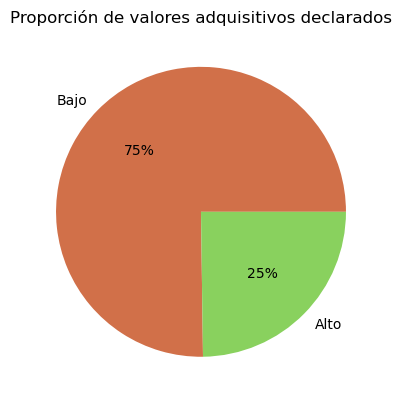

In [141]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
plt.title('Proporción de valores adquisitivos declarados')
plt.pie(df.tiene_alto_valor_adquisitivo.value_counts().sort_index(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Si queremos ser mas exactos con las cantidades

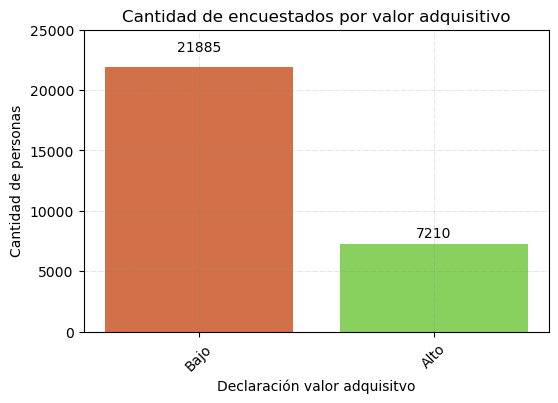

In [142]:
fig, ax = plt.subplots(dpi=100)
rects1 = ax.bar(['Bajo', 'Alto'], df.tiene_alto_valor_adquisitivo.value_counts().values,  color=['#D17049',"#89D15E"])

plt.ylabel("Cantidad de personas")
plt.xlabel("Declaración valor adquisitvo")
plt.title("Cantidad de encuestados por valor adquisitivo")
plt.xticks(rotation=45)

for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')
        
plt.yticks(np.arange(0,30000, 5000))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

### CONFIGURAR BIEN ESTO PARA MOSTRAR 2 EN 1:

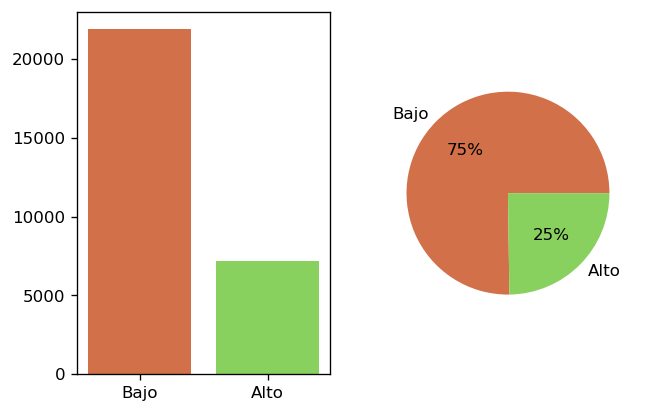

In [143]:
fig, ax = plt.subplots(ncols = 2, dpi=120)
rects1 = ax[0].bar(['Bajo', 'Alto'], df.tiene_alto_valor_adquisitivo.value_counts().values,  color=['#D17049',"#89D15E"])
dos = ax[1].pie(df.tiene_alto_valor_adquisitivo.value_counts().sort_index(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')


Podemos observar que solo un 25% (7210 personas) han declarado tener alto valor adquisitivo, lo cual podemos concluir que no es una feature muy interesante. En caso de que nos haya dado un alto valor adquisitivo no podemos quedarnos con ésta sola feature a prori, ya que la razón por.. **JUSTIFICAR CON LO QUE DIJERON EN LA PRÁCTICA 04/05/21**

## ¿Cómo es la distribución de los Barrios?

Para responder ésta pregunta primero veamos cuantos son los barrios que han sido cargados


In [41]:
print('Cantidad barrios únicos: ', df.barrio.value_counts().nunique())

Cantidad barrios únicos:  37


Una altisima cantidad de barrios ingresados, es decir, una alta cardinalidad para ésta feature.

Veamos la cantidad de encuestados por barrio

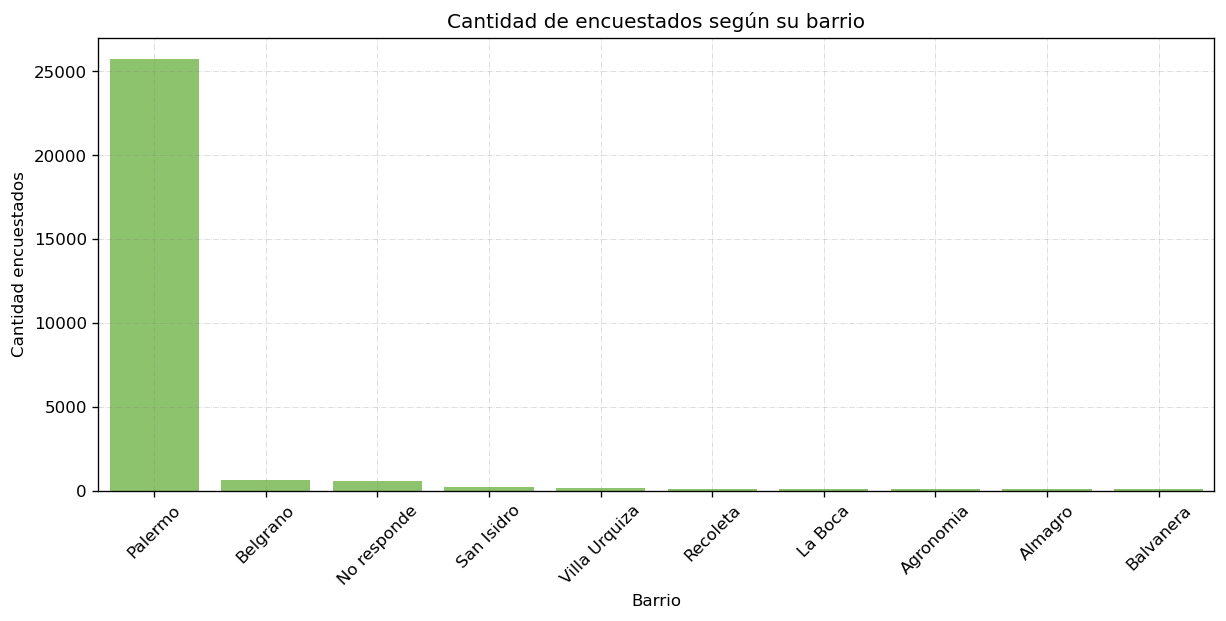

In [42]:
cantidad_barrios_visualizados = 10

plt.figure(dpi=120,figsize =(12, 5))
sns.countplot(
    x="barrio",
    data=df,
    order=df["barrio"].value_counts().iloc[:cantidad_barrios_visualizados].index,
    color='#89D15E',
)

plt.ylabel("Cantidad encuestados")
plt.xlabel("Barrio")
plt.title("Cantidad de encuestados según su barrio")
plt.xticks(rotation=45)

plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

Lo cual se peude notar una altisima cantidad de encuestados provenientes de Palermo, por ende no podemos decir mucho a priori. Es mas, notar que solo graficamos 10 barrios de los 37 posibles que hay, en orden descendiente.

Si nos guiamos con proporciones

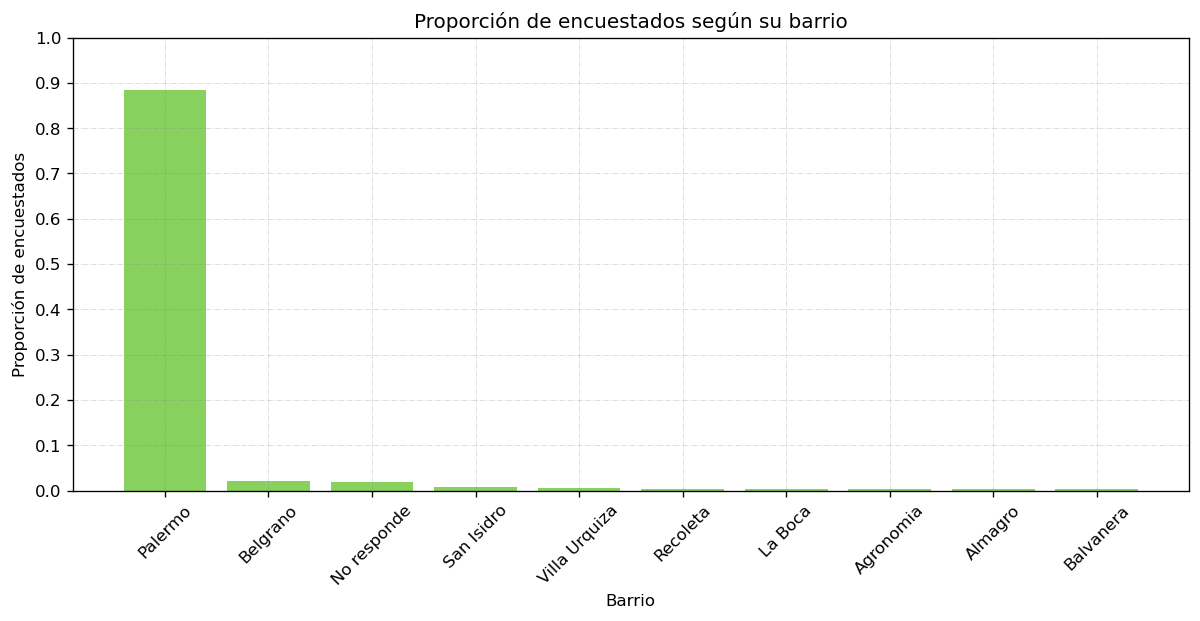

In [43]:
cantidad_barrios_visualizados = 10

plt.figure(dpi=120,figsize =(12, 5))
barrios = (
    df['barrio']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
)
ax = plt.bar(barrios.iloc[:cantidad_barrios_visualizados].index, barrios.iloc[:cantidad_barrios_visualizados].values, color = '#89D15E')

plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.ylabel("Proporción de encuestados")
plt.xlabel("Barrio")
plt.title("Proporción de encuestados según su barrio")
plt.xticks(rotation=45)
plt.yticks(np.arange(0,1.1, 0.1))
plt.show()

De la misma forma, era evidente observar que casi un 90% de las personas que fueron encuestadas fueron de Palermo y, en las demás comunas de la ciudad no llega ni al 1% de encuestados.

Podriamos averiguar la cantidad de personas en Palermo respecto si tienen alto nivel adquisito o no

### ¿En Palermo, hay inidicios de tener alto valor adquisitivo?

Teniendo en cuenta que Palermo es el barrio con mayor proporción de personas, preguntemosnos algo respecto valor adquisitivo

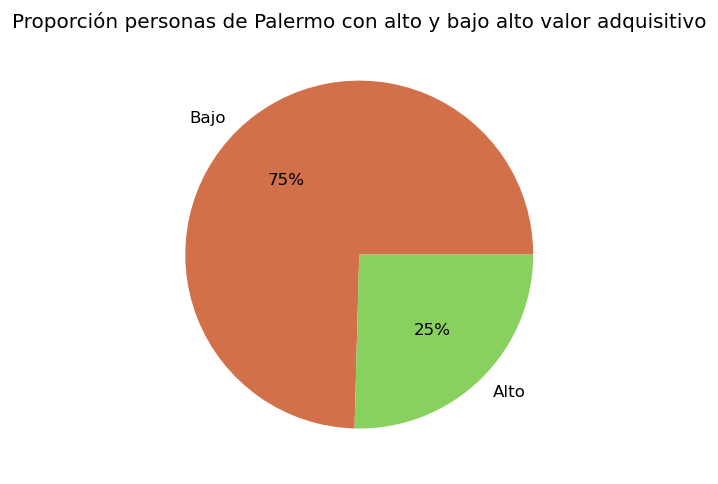

In [44]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.title('Proporción personas de Palermo con alto y bajo alto valor adquisitivo')
plt.pie(df[df.barrio == 'Palermo'].tiene_alto_valor_adquisitivo.value_counts().sort_index(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Es decir un 25% de las personas que habitan en la comuna de Palermo de CABA tienen un alto nivel adquisitivo. Pero a prori no nos dice mucha información ni responde nuestra pregunta. Quizás nos podrá ser interesante para futuras relaciones entre diferentes features.

Es conclusión si respondemos a la pregunta inicial que nos realizamos *"¿Cómo es la distribución de los Barrios?"*
Vimos que es una distribución poco equitativa y que a prori no nos muestra mucha ifnormación ni podemos buscar algun patón relacionandolos con el valor adquisitivo.

Tambien vimos la relacion con el barrio Palermo, y concluimos que vivir en Palermo no implica tener declarado un alto valor adquisitivo.


## ¿Hay relación entre la Edad y el Genero?

### ¿El Barrio en el que uno habita, influye con la Edad?

#### ¿Y la edad?

### ¿Hay igualdad de Genero en los valores adquisitivos declarados?

### ¿Hay un rango de edades influyente en cada genero que dé indicios de tener alto valor adquisitivo?